In [13]:
from jiwer import wer, cer
import json
import os

# Function to load data from a JSON file
def load_json_data(json_filepath: str):
    """
    Loads data from a JSON file and returns it as a Python dictionary.

    Args:
        json_filepath (str): Path to the JSON file.

    Returns:
        dict: Parsed JSON data.
    """
    with open(json_filepath, 'r', encoding='utf-8') as file:
        return json.load(file)

# Paths to the JSON files for DIMAURO and MOLINETTE datasets
dimauro_json_filepath = r'/Users/benedettaperrone/Documents/TESI/VISUAL_STUDIO_CODE/whisper/DIMAURO/DIMAURO_new.json'
molinette_json_filepath = r'/Users/benedettaperrone/Documents/TESI/VISUAL_STUDIO_CODE/whisper/MOLINETTE_combined/MOLINETTE_combined.json'

# Load JSON data
dimauro_data = load_json_data(dimauro_json_filepath)
molinette_data = load_json_data(molinette_json_filepath)

# Function to extract the patient ID from the filename in the DIMAURO dataset
def extract_id_from_filename(filename: str) -> str:
    """
    Extracts the patient ID from the filename based on specific patterns.

    Args:
        filename (str): The filename to extract the ID from.

    Returns:
        str: Extracted patient ID.
    """
    if filename.startswith(('B1', 'B2')):
        patient_id = filename[2:].split('.')[0]
    elif filename.startswith(('FB1', 'PR1')):
        patient_id = filename[3:].split('.')[0]
    else:
        patient_id = ''

    # Logic to extract ID based on the presence of two digits followed by 'F' or 'M'
    age_found = False
    for i in range(len(patient_id)):
        if patient_id[i].isdigit() and not age_found:
            if i + 1 < len(patient_id) and patient_id[i+1].isdigit():
                age_found = True
        elif age_found and patient_id[i] in ['F', 'M']:
            patient_id = patient_id[:i+1]
            break
    return patient_id

def extract_id_from_molinette_filename(filename: str) -> tuple:
    """
    Extracts the patient ID and on_off status from the MOLINETTE filename based on the pattern after the first 'P'.

    Args:
        filename (str): The filename to extract the ID and on_off status from.

    Returns:
        tuple: (patient_id (str), on_off (str or None))
    """
    patient_id = ''
    on_off = None
    
    if filename.startswith('P'):
        # Extract ID for filenames that start with 'P'
        p_index = filename.find('P') + 1  # Get the index just after 'P'
        while p_index < len(filename) and filename[p_index].isdigit():
            patient_id += filename[p_index]
            p_index += 1
        if 'ON' in filename:
            on_off = 'on'
        elif 'OFF' in filename:
            on_off = 'off'
    elif filename.startswith('OP'):
        # Extract ID for filenames that start with 'OP'
        patient_id = filename[:5]  # Take 'OP' + first 3 digits as ID
        on_off = 'on'  # Files with 'OP' are assumed to be 'on'
        
    return patient_id, on_off


# Function to extract the ID and on_off status based on the dataset
def extract_id(filename: str, dataset: str) -> tuple:
    """
    Determines the correct ID extraction function based on the dataset.

    Args:
        filename (str): The filename to extract the ID from.
        dataset (str): The dataset name ('DIMAURO' or 'MOLINETTE').

    Returns:
        tuple: (file_id (str), file_onoff (str or None))
    """
    if dataset == 'DIMAURO':
        file_id = extract_id_from_filename(filename)
        return file_id, None  # file_onoff is not present in DIMAURO
    elif dataset == 'MOLINETTE':
        file_id, file_onoff = extract_id_from_molinette_filename(filename)
        return file_id, file_onoff
    else:
        raise ValueError("Dataset not recognized. Use 'DIMAURO' or 'MOLINETTE'.")

# Function to determine the group, task, and UPDRS based on file ID and dataset
def determine_group_and_task(file_id: str, json_data, dataset: str, file_onoff: str = None) -> tuple:
    """
    Determines the group (control or parkinson), task, and UPDRS associated with a file.

    Args:
        file_id (str): The extracted file ID.
        json_data (dict): The loaded JSON data for the dataset.
        dataset (str): The dataset name ('DIMAURO' or 'MOLINETTE').
        file_onoff (str, optional): The on_off status for MOLINETTE dataset. Defaults to None.

    Returns:
        tuple: (group (str), task (str), updrs (int or None))
    """
    for entry in json_data:
        if dataset == 'MOLINETTE':
            if entry['id'] == file_id and entry.get('on_off') == file_onoff:
                task = entry['task'].replace(' ', '').lower()
                if task == 'proverb':
                    group = 'parkinson'  # MOLINETTE dataset has only parkinson patients
                    updrs = entry.get('updrs', None)
                    return group, task, updrs
        elif dataset == 'DIMAURO':
            if entry['id'] == file_id:
                task = entry['task'].replace(' ', '').lower()
                if task in ['readtext', 'phrases', 'words']:
                    group = 'control' if entry['label'] == 0 else 'parkinson'
                    updrs = entry.get('UPDRS', None)
                    return group, task, updrs
    return 'unknown', 'unknown', None

# Function to read the content of a text file
def read_file(filepath: str) -> str:
    """
    Reads the content of a text file.

    Args:
        filepath (str): Path to the text file.

    Returns:
        str: Content of the file.
    """
    with open(filepath, 'r', encoding='utf-8') as file:
        return file.read().strip()

# Function to determine the reference text for MOLINETTE based on the filename
def get_reference_text_molinette(filename: str) -> str:
    """
    Determines the correct reference text for a MOLINETTE file based on its name.

    Args:
        filename (str): The filename to determine the reference text for.

    Returns:
        str or None: The reference text or None if not applicable.
    """
    if 'PR1a' in filename or 'PR1b' in filename:
        return 'A caval donato non si guarda in bocca'
    elif 'PR2a' in filename or 'PR2b' in filename:
        return 'Meglio soli che mal accompagnati'
    return None

# Function to calculate WER and CER for control and parkinson groups
def calculate_wer_cer_for_groups(directory: str, json_data, reference_texts: dict, dataset: str) -> dict:
    """
    Calculates WER and CER for control and parkinson groups based on reference texts.

    Args:
        directory (str): Path to the directory containing text files.
        json_data (dict): Loaded JSON data for the dataset.
        reference_texts (dict): Reference texts for the tasks.
        dataset (str): Dataset name ('DIMAURO' or 'MOLINETTE').

    Returns:
        dict: Calculated WER and CER statistics.
    """
    # Lists to store WER and CER values
    control_wer = []
    parkinsonian_wer = []
    control_cer = []
    parkinsonian_cer = []

    # Dictionaries to store WER and CER by UPDRS level
    parkinsonian_wer_by_updrs = {i: [] for i in range(5)}  # Considering UPDRS 0-4
    parkinsonian_cer_by_updrs = {i: [] for i in range(5)}

    # List of all .txt files in the directory
    files = [f for f in os.listdir(directory) if f.endswith('.txt')]

    # Counters for the number of files in each group and UPDRS level
    control_files_count = 0
    parkinsonian_files_count = 0
    updrs_files_count = {i: 0 for i in range(5)}

    for file in files:
        # Extract file_id and file_onoff (if applicable)
        file_id, file_onoff = extract_id(file, dataset)
        if file_id is None:
            continue

        # Determine group, task, and UPDRS
        group, task, updrs = determine_group_and_task(file_id, json_data, dataset, file_onoff)
        if group == 'unknown' or task == 'unknown':
            continue

        # Get the reference text based on the dataset and task
        if dataset == 'MOLINETTE':
            reference = get_reference_text_molinette(file)
        else:
            reference = reference_texts.get(task, None)

        if reference is None:
            continue

        # Read the hypothesis text from the file
        file_path = os.path.join(directory, file)
        hypothesis = read_file(file_path)

        # Calculate WER and CER
        wer_value = wer(reference, hypothesis)
        cer_value = cer(reference, hypothesis)

        # Assign WER and CER to the appropriate group and UPDRS level
        if group == 'control':
            control_wer.append(wer_value)
            control_cer.append(cer_value)
            control_files_count += 1
        elif group == 'parkinson':
            parkinsonian_wer.append(wer_value)
            parkinsonian_cer.append(cer_value)
            parkinsonian_files_count += 1
            if updrs is not None and updrs in updrs_files_count:
                parkinsonian_wer_by_updrs[updrs].append(wer_value)
                parkinsonian_cer_by_updrs[updrs].append(cer_value)
                updrs_files_count[updrs] += 1

    # Calculate average WER and CER for control and parkinson groups
    avg_control_wer = sum(control_wer) / len(control_wer) if control_wer else float('inf')
    avg_parkinsonian_wer = sum(parkinsonian_wer) / len(parkinsonian_wer) if parkinsonian_wer else float('inf')
    avg_control_cer = sum(control_cer) / len(control_cer) if control_cer else float('inf')
    avg_parkinsonian_cer = sum(parkinsonian_cer) / len(parkinsonian_cer) if parkinsonian_cer else float('inf')
    median_control_wer = sorted(control_wer)[len(control_wer) // 2] if control_wer else float('inf')
    median_control_cer = sorted(control_cer)[len(control_cer) // 2] if control_cer else float('inf')
    median_parkinsonian_wer = sorted(parkinsonian_wer)[len(parkinsonian_wer) // 2] if parkinsonian_wer else float('inf')
    median_parkinsonian_cer = sorted(parkinsonian_cer)[len(parkinsonian_cer) // 2] if parkinsonian_cer else float('inf')
    
    median_parkinsonian_wer_by_updrs = {
        i: sorted(parkinsonian_wer_by_updrs[i])[len(parkinsonian_wer_by_updrs[i]) // 2] if parkinsonian_wer_by_updrs[i] else float('inf')
        for i in range(5)
    }
    
    median_parkinsonian_cer_by_updrs = {
        i: sorted(parkinsonian_cer_by_updrs[i])[len(parkinsonian_cer_by_updrs[i]) // 2] if parkinsonian_cer_by_updrs[i] else float('inf')
        for i in range(5)
    }
    
    # Calculate average WER and CER by UPDRS level
    avg_parkinsonian_wer_by_updrs = {
        i: (sum(parkinsonian_wer_by_updrs[i]) / len(parkinsonian_wer_by_updrs[i])) if parkinsonian_wer_by_updrs[i] else float('inf') 
        for i in range(5)
    }
    avg_parkinsonian_cer_by_updrs = {
        i: (sum(parkinsonian_cer_by_updrs[i]) / len(parkinsonian_cer_by_updrs[i])) if parkinsonian_cer_by_updrs[i] else float('inf') 
        for i in range(5)
    }

    return {
        'control_wer': avg_control_wer,
        'parkinsonian_wer': avg_parkinsonian_wer,
        'control_cer': avg_control_cer,
        'parkinsonian_cer': avg_parkinsonian_cer,
        'control_files_count': control_files_count,
        'parkinsonian_files_count': parkinsonian_files_count,
        'updrs_files_count': updrs_files_count,
        'parkinsonian_wer_by_updrs': avg_parkinsonian_wer_by_updrs,
        'parkinsonian_cer_by_updrs': avg_parkinsonian_cer_by_updrs,
        'individual_parkinsonian_wer': parkinsonian_wer_by_updrs,
        'individual_parkinsonian_cer': parkinsonian_cer_by_updrs,
        'median_control_wer': median_control_wer,
        'median_control_cer': median_control_cer,
        'median_parkinsonian_wer': median_parkinsonian_wer,
        'median_parkinsonian_cer': median_parkinsonian_cer,
        'median_parkinsonian_wer_by_updrs': median_parkinsonian_wer_by_updrs,
        'median_parkinsonian_cer_by_updrs': median_parkinsonian_cer_by_updrs
        
    }


from statistics import mean, median, stdev


from statistics import mean, median, stdev

# Function to integrate the results from DIMAURO and MOLINETTE datasets
def integrate_results(dimauro_results: dict, molinette_results: dict) -> dict:
    """
    Integrates WER and CER results from DIMAURO and MOLINETTE datasets by UPDRS levels,
    calculating both unweighted and weighted averages.

    Args:
        dimauro_results (dict): WER and CER statistics from DIMAURO dataset.
        molinette_results (dict): WER and CER statistics from MOLINETTE dataset.

    Returns:
        dict: Combined WER and CER statistics with both unweighted and weighted averages.
    """
    combined_stats = {
        'combined_wer': {},
        'combined_cer': {},
        'total_files_by_updrs': {}
    }

    # Only consider UPDRS levels 0, 1, and 2
    updrs_levels = {0, 1, 2}

    for i in updrs_levels:
        # Number of files for DIMAURO and MOLINETTE for UPDRS level i
        dimauro_count = dimauro_results['updrs_files_count'].get(i, 0)
        molinette_count = molinette_results['updrs_files_count'].get(i, 0)
        total_files = dimauro_count + molinette_count
        combined_stats['total_files_by_updrs'][i] = total_files

        print(f"\nUPDRS Level {i}")
        print(f"DIMAURO file count: {dimauro_count}, MOLINETTE file count: {molinette_count}, Total files: {total_files}")

        # Retrieve individual WER and CER values for each UPDRS level
        dimauro_wer_values = dimauro_results['individual_parkinsonian_wer'].get(i, [])
        molinette_wer_values = molinette_results['individual_parkinsonian_wer'].get(i, [])
        dimauro_cer_values = dimauro_results['individual_parkinsonian_cer'].get(i, [])
        molinette_cer_values = molinette_results['individual_parkinsonian_cer'].get(i, [])

        # Combine individual WER and CER values from both datasets
        combined_wer_values = dimauro_wer_values + molinette_wer_values
        combined_cer_values = dimauro_cer_values + molinette_cer_values
        print(f"Combined WER values: {combined_wer_values}")
        print(f"Combined CER values: {combined_cer_values}")

        if total_files > 0:
            # Unweighted Average (Simple Mean) Calculation
            combined_wer_unweighted = mean(combined_wer_values) if combined_wer_values else float('inf')
            combined_cer_unweighted = mean(combined_cer_values) if combined_cer_values else float('inf')
            print(f"Unweighted WER: {combined_wer_unweighted}, Unweighted CER: {combined_cer_unweighted}")

            # Weighted Average Calculation
            # Sum of weighted WER and CER values
            combined_wer_weighted = (
                sum(w * dimauro_count for w in dimauro_wer_values) + sum(w * molinette_count for w in molinette_wer_values)
            ) / (len(dimauro_wer_values) * dimauro_count + len(molinette_wer_values) * molinette_count) if combined_wer_values else float('inf')

            combined_cer_weighted = (
                sum(c * dimauro_count for c in dimauro_cer_values) + sum(c * molinette_count for c in molinette_cer_values)
            ) / (len(dimauro_cer_values) * dimauro_count + len(molinette_cer_values) * molinette_count) if combined_cer_values else float('inf')

            print(f"Weighted WER: {combined_wer_weighted}, Weighted CER: {combined_cer_weighted}")

            # Store results in combined_stats dictionary, including the list of individual values
            combined_stats['combined_wer'][i] = {
                'mean_unweighted': combined_wer_unweighted,
                'mean_weighted': combined_wer_weighted,
                'median': median(combined_wer_values) if combined_wer_values else float('inf'),
                'stdev': stdev(combined_wer_values) if len(combined_wer_values) > 1 else 0,
                'values': combined_wer_values  # Store raw WER values
            }

            combined_stats['combined_cer'][i] = {
                'mean_unweighted': combined_cer_unweighted,
                'mean_weighted': combined_cer_weighted,
                'median': median(combined_cer_values) if combined_cer_values else float('inf'),
                'stdev': stdev(combined_cer_values) if len(combined_cer_values) > 1 else 0,
                'values': combined_cer_values  # Store raw CER values
            }

        else:
            # If no files for this UPDRS level, set to infinity
            combined_stats['combined_wer'][i] = {
                'mean_unweighted': float('inf'), 'mean_weighted': float('inf'),
                'median': float('inf'), 'stdev': float('inf'), 'values': []
            }
            combined_stats['combined_cer'][i] = {
                'mean_unweighted': float('inf'), 'mean_weighted': float('inf'),
                'median': float('inf'), 'stdev': float('inf'), 'values': []
            }

    return combined_stats





# Define the paths and reference texts for the DIMAURO dataset
dimauro_directory = r"/Users/benedettaperrone/Documents/TESI/VISUAL_STUDIO_CODE/whisper/DIMAURO/dati"
dimauro_reference_texts = {
    'readtext': (
        'Il ramarro della zia. Il papà (o il babbo come dice il piccolo Dado) era sul letto. '
        'Sotto di lui, accanto al lago, sedeva Gigi, detto Ciccio, cocco della mamma e della nonna. '
        'Vicino ad un sasso c’era una rosa rosso vivo e lo sciocco, vedendola, la volle per la zia. '
        'La zia Lulù cercava zanzare per il suo ramarro, ma dato che era giugno (o luglio non so bene) '
        'non ne trovava. Trovò invece una rana che saltando dalla strada finì nel lago con un grande spruzzo. '
        'Sai che fifa, la zia! Lo schizzo bagnò il suo completo rosa che divenne giallo come un taxi. '
        'Passava di lì un signore cosmopolita di nome Sardanapalo Nabucodonosor che si innamorò della zia '
        'e la portò con sé in Afghanistan.'
    ),
    'words': (
        'pipa, buco, topo, dado, casa, gatto, filo, vaso, muro, neve, luna, rete, zero, scia, '
        'ciao, giro, sole, uomo, iuta, gnomo, glielo, pozzo, brodo, plagio, treno, classe, grigio, '
        'flotta, creta, drago, frate, spesa, stufa, scala, slitta, splende, strada, scrive, spruzzo, '
        'sgrido, sfregio, sdraio, sbrigo, prova, calendario, autobiografia, monotono, pericoloso, '
        'montagnoso, prestigioso.'
    ),
    'phrases': (
        'Oggi è una bella giornata per sciare. Voglio una maglia di lana color ocra. '
        'Il motociclista attraversò una strada stretta di montagna. Patrizia ha pranzato a casa di Fabio. '
        'Questo è il tuo cappello? Dopo vieni a casa? La televisione funziona? Non posso aiutarti? '
        'Marco non è partito. Il medico non è impegnato.'
    )
}

# Calculate results for the DIMAURO dataset
dimauro_results = calculate_wer_cer_for_groups(dimauro_directory, dimauro_data, dimauro_reference_texts, 'DIMAURO')

# Define the paths and reference texts for the MOLINETTE dataset
molinette_directory = r'/Users/benedettaperrone/Documents/TESI/VISUAL_STUDIO_CODE/whisper/MOLINETTE_combined/dati'

# Calculate results for the MOLINETTE dataset
molinette_results = calculate_wer_cer_for_groups(molinette_directory, molinette_data, {}, 'MOLINETTE')

final_results = integrate_results(dimauro_results, molinette_results)





UPDRS Level 0
DIMAURO file count: 44, MOLINETTE file count: 24, Total files: 68
Combined WER values: [0.96875, 1.0, 0.4921875, 0.4453125, 0.4609375, 0.9609375, 0.9921875, 1.0, 1.0, 0.4375, 0.4609375, 0.9609375, 0.9609375, 1.0, 0.2890625, 0.4921875, 0.4296875, 0.5625, 0.390625, 0.96875, 1.0, 1.0, 0.4140625, 0.96875, 1.0, 0.4453125, 1.0, 0.375, 0.9609375, 1.0, 0.46875, 0.9609375, 0.3671875, 0.7109375, 0.4140625, 0.4140625, 0.328125, 0.6328125, 1.0, 0.5078125, 0.5546875, 0.9609375, 0.96875, 0.9609375, 0.8, 0.8, 0.6, 0.125, 0.6, 0.5, 0.25, 0.6, 0.5, 0.6, 0.6, 0.6, 0.375, 0.375, 0.25, 0.6, 0.125, 0.2, 0.375, 0.6, 0.625, 0.2, 0.375, 0.375]
Combined CER values: [0.7558479532163743, 0.7441520467836257, 0.23391812865497075, 0.16228070175438597, 0.1915204678362573, 0.7558479532163743, 0.7397660818713451, 0.7353801169590644, 0.7441520467836257, 0.1652046783625731, 0.16228070175438597, 0.7587719298245614, 0.7470760233918129, 0.7456140350877193, 0.1067251461988304, 0.16228070175438597, 0.140350877

In [14]:
import pandas as pd

def display_and_save_results_as_table(dimauro_results, molinette_results, final_results, output_filename="summary_results_italiano.xlsx"):
    # Helper function to round values to 5 decimal places
    def round_values(value):
        if isinstance(value, (int, float)):
            return round(value, 5)
        return value

    # Create DataFrames for DIMAURO and MOLINETTE results
    dimauro_general_df = pd.DataFrame({
        'Metric': ['Control WER', 'Parkinsonian WER', 'Control CER', 'Parkinsonian CER', 'Control Files Count', 'Parkinsonian Files Count'],
        'Value': [round_values(dimauro_results['control_wer']), round_values(dimauro_results['parkinsonian_wer']), 
                  round_values(dimauro_results['control_cer']), round_values(dimauro_results['parkinsonian_cer']), 
                  dimauro_results['control_files_count'], dimauro_results['parkinsonian_files_count']]
    })

    molinette_general_df = pd.DataFrame({
        'Metric': ['Control WER', 'Parkinsonian WER', 'Control CER', 'Parkinsonian CER', 'Control Files Count', 'Parkinsonian Files Count'],
        'Value': [round_values(molinette_results['control_wer']), round_values(molinette_results['parkinsonian_wer']), 
                  round_values(molinette_results['control_cer']), round_values(molinette_results['parkinsonian_cer']), 
                  molinette_results['control_files_count'], molinette_results['parkinsonian_files_count']]
    })

    # Create DataFrames for DIMAURO results by UPDRS level
    dimauro_updrs_df = pd.DataFrame({
        'UPDRS Level': list(dimauro_results['updrs_files_count'].keys()),
        'WER': [round_values(dimauro_results['parkinsonian_wer_by_updrs'][level]) for level in dimauro_results['updrs_files_count']],
        'CER': [round_values(dimauro_results['parkinsonian_cer_by_updrs'][level]) for level in dimauro_results['updrs_files_count']],
        'Files Count': [dimauro_results['updrs_files_count'][level] for level in dimauro_results['updrs_files_count']]
    })

    # Create DataFrame for MOLINETTE results by UPDRS level
    molinette_updrs_df = pd.DataFrame({
        'UPDRS Level': list(molinette_results['updrs_files_count'].keys()),
        'WER': [round_values(molinette_results['parkinsonian_wer_by_updrs'][level]) for level in molinette_results['updrs_files_count']],
        'CER': [round_values(molinette_results['parkinsonian_cer_by_updrs'][level]) for level in molinette_results['updrs_files_count']],
        'Files Count': [molinette_results['updrs_files_count'][level] for level in molinette_results['updrs_files_count']]
    })

    # Create DataFrame for combined results
    combined_results_df = pd.DataFrame({
        'UPDRS Level': list(final_results['combined_wer'].keys()),
        'WER Mean': [round_values(final_results['combined_wer'][level]['mean_unweighted']) for level in final_results['combined_wer']],
        'WER Median': [round_values(final_results['combined_wer'][level]['median']) for level in final_results['combined_wer']],
        'WER Stdev': [round_values(final_results['combined_wer'][level]['stdev']) for level in final_results['combined_wer']],
        'CER Mean': [round_values(final_results['combined_cer'][level]['mean_unweighted']) for level in final_results['combined_cer']],
        'CER Median': [round_values(final_results['combined_cer'][level]['median']) for level in final_results['combined_cer']],
        'CER Stdev': [round_values(final_results['combined_cer'][level]['stdev']) for level in final_results['combined_cer']],
        'Files Count': [final_results['total_files_by_updrs'][level] for level in final_results['combined_wer']]
    })

    # Create DataFrame for individual WER and CER values by UPDRS level
    individual_values_df = pd.DataFrame({
        'UPDRS Level': list(final_results['combined_wer'].keys()),
        'Individual WER Values': [final_results['combined_wer'][level]['values'] for level in final_results['combined_wer']],
        'Individual CER Values': [final_results['combined_cer'][level]['values'] for level in final_results['combined_cer']]
    })

    # Display the DataFrames
    print("DIMAURO Results (General):")
    display(dimauro_general_df)
    print("\nDIMAURO Results by UPDRS Level:")
    display(dimauro_updrs_df)
    print("\nMOLINETTE Results (General):")
    display(molinette_general_df)
    print("\nMOLINETTE Results by UPDRS Level:")
    display(molinette_updrs_df)
    print("\nCombined Results:")
    display(combined_results_df)
    print("\nIndividual WER and CER Values by UPDRS Level:")
    display(individual_values_df)

    # Save the DataFrames to a CSV file
    with pd.ExcelWriter(output_filename) as writer:
        dimauro_general_df.to_excel(writer, sheet_name='DIMAURO General', index=False)
        dimauro_updrs_df.to_excel(writer, sheet_name='DIMAURO UPDRS', index=False)
        molinette_general_df.to_excel(writer, sheet_name='MOLINETTE General', index=False)
        molinette_updrs_df.to_excel(writer, sheet_name='MOLINETTE UPDRS', index=False)
        combined_results_df.to_excel(writer, sheet_name='Combined Results', index=False)
        individual_values_df.to_excel(writer, sheet_name='Individual Values', index=False)

# Call the function to display the results as tables and save them to a CSV file
display_and_save_results_as_table(dimauro_results, molinette_results, final_results)


DIMAURO Results (General):


,Metric,Value
0,Control WER,0.649800
1,Parkinsonian WER,0.753390
2,Control CER,0.400320
3,Parkinsonian CER,0.504430
4,Control Files Count,130.000000
5,Parkinsonian Files Count,106.000000



DIMAURO Results by UPDRS Level:


,UPDRS Level,WER,CER,Files Count
0,0,0.720170,0.461920,44
1,1,0.727680,0.485510,35
2,2,0.808590,0.571350,20
3,3,0.908850,0.666180,3
4,4,0.951170,0.681650,4



MOLINETTE Results (General):


,Metric,Value
0,Control WER,inf
1,Parkinsonian WER,0.646560
2,Control CER,inf
3,Parkinsonian CER,0.243110
4,Control Files Count,0.000000
5,Parkinsonian Files Count,80.000000



MOLINETTE Results by UPDRS Level:


,UPDRS Level,WER,CER,Files Count
0,0,0.460420,0.122180,24
1,1,0.551040,0.162480,24
2,2,0.857810,0.394270,32
3,3,inf,inf,0
4,4,inf,inf,0



Combined Results:


,UPDRS Level,WER Mean,WER Median,WER Stdev,CER Mean,CER Median,CER Stdev,Files Count
0,0,0.628490,0.600000,0.277390,0.342010,0.166670,0.289960,68
1,1,0.655830,0.600000,0.319680,0.354100,0.171050,0.319240,59
2,2,0.838880,0.914060,0.386450,0.462370,0.265620,0.387630,52



Individual WER and CER Values by UPDRS Level:


,UPDRS Level,Individual WER Values,Individual CER Values
0,0,"[0.96875, 1.0, 0.4921875, 0.4453125, 0.4609375...","[0.7558479532163743, 0.7441520467836257, 0.233..."
1,1,"[0.9609375, 0.9609375, 0.2890625, 0.984375, 0....","[0.7558479532163743, 0.7587719298245614, 0.093..."
2,2,"[0.953125, 0.3828125, 1.421875, 0.953125, 0.60...","[0.7573099415204678, 0.1154970760233918, 1.108..."



### WER - UPDRS 0 ###
Total Outliers: 0
Outlier Values: []

### WER - UPDRS 1 ###
Total Outliers: 1
Outlier Values: [1.875]

### WER - UPDRS 2 ###
Total Outliers: 1
Outlier Values: [2.2]


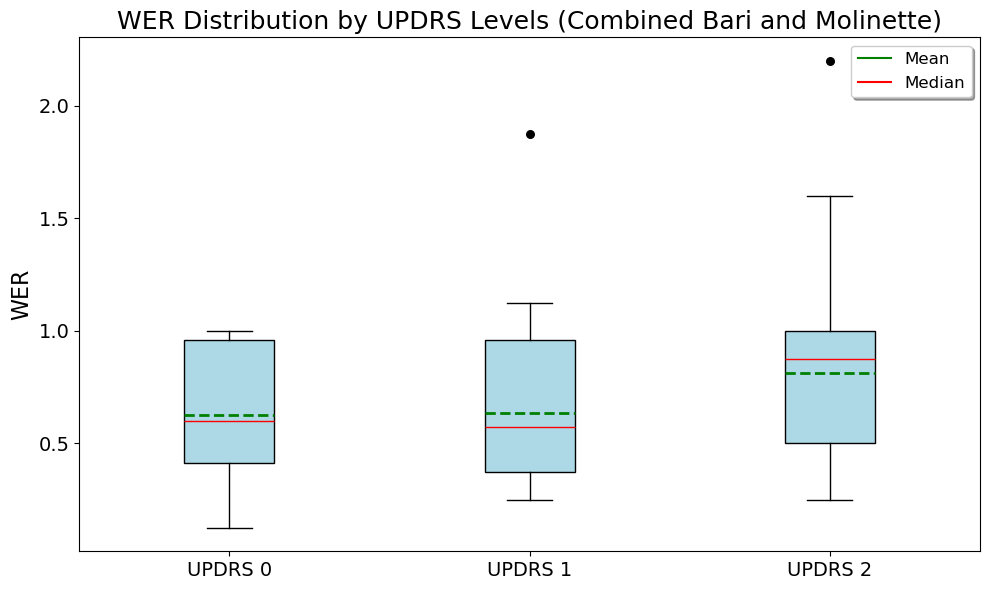


### CER - UPDRS 0 ###
Total Outliers: 0
Outlier Values: []

### CER - UPDRS 1 ###
Total Outliers: 0
Outlier Values: []

### CER - UPDRS 2 ###
Total Outliers: 0
Outlier Values: []


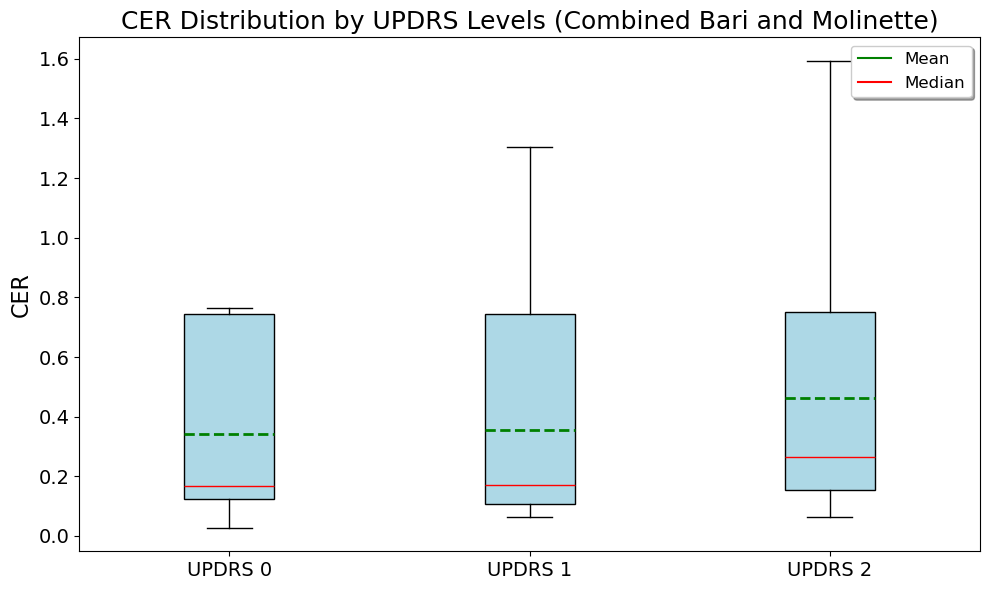

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Function to remove outliers using Tukey's IQR method
def remove_outliers_iqr(data):
    """Removes outliers using Tukey's IQR method and returns the clean data along with the list of outliers."""
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Filter data into clean data and outliers
    filtered_data = [x for x in data if lower_bound <= x <= upper_bound]
    outliers = [x for x in data if x < lower_bound or x > upper_bound]
    
    return filtered_data, outliers

# Function to process data and identify outliers for UPDRS levels 0, 1, and 2
def prepare_data_and_outliers(data_by_updrs, metric_name):
    """
    Prepares clean data and outliers for UPDRS levels 0, 1, and 2 by applying remove_outliers_iqr,
    and prints information about the outliers.
    
    Args:
        data_by_updrs (dict): Dictionary with UPDRS levels as keys and lists of data as values.
        metric_name (str): Name of the metric (WER or CER).
    
    Returns:
        clean_data_by_updrs (dict): Dictionary with UPDRS levels as keys and cleaned data as values.
        outliers_by_updrs (dict): Dictionary with UPDRS levels as keys and outliers as values.
    """
    clean_data_by_updrs = {}
    outliers_by_updrs = {}
    
    for updrs_level in [0, 1, 2]:  # Only process UPDRS levels 0, 1, and 2
        # Extract individual values for this UPDRS level
        data = data_by_updrs.get(updrs_level, {}).get('values', [])
        
        # Process outliers
        clean_data, outliers = remove_outliers_iqr(data)
        clean_data_by_updrs[updrs_level] = clean_data
        outliers_by_updrs[updrs_level] = outliers
        
        # Print information about outliers
        print(f"\n### {metric_name} - UPDRS {updrs_level} ###")
        print(f"Total Outliers: {len(outliers)}")
        print("Outlier Values:", outliers)
    
    return clean_data_by_updrs, outliers_by_updrs

# Function to plot boxplots with manual outliers for WER/CER data by UPDRS level
def plot_boxplots_with_outliers(data_by_updrs, outliers_by_updrs, metric_name="WER", dataset_label="Combined Bari and Molinette"):
    """
    Plots separate boxplots for UPDRS levels 0, 1, and 2, and manually adds outliers using scatter to ensure visibility.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Prepare data for box plot using clean data for UPDRS levels 0, 1, and 2
    data = [data_by_updrs[updrs] for updrs in [0, 1, 2]]
    labels = [f'UPDRS {updrs}' for updrs in [0, 1, 2]]
    
    box = ax.boxplot(data, patch_artist=True, showmeans=True, meanline=True,
                     labels=labels,
                     widths=0.3,
                     boxprops=dict(facecolor='lightblue', color='black'),
                     medianprops=dict(color='red'),
                     meanprops=dict(color='green', linewidth=2, marker=''),
                     whiskerprops=dict(color='black'),
                     capprops=dict(color='black'),
                     flierprops=dict(marker='', markersize=0))  # Disable automatic outlier markers

    # Add custom legend for Mean and Median
    handles = [plt.Line2D([0], [0], color='green', label='Mean', linestyle='-'),
               plt.Line2D([0], [0], color='red', label='Median', linestyle='-')]
    ax.legend(handles=handles, loc='upper right', frameon=True, shadow=True, fontsize=12)
    
    # Plot outliers manually using scatter
    for updrs_level, outliers in outliers_by_updrs.items():
        if updrs_level in [0, 1, 2]:  # Only plot for UPDRS levels 0, 1, and 2
            x_positions = np.full(len(outliers), [0, 1, 2].index(updrs_level) + 1)
            ax.scatter(x_positions, outliers, color='black', marker='o', s=30)
    
    # Add title and labels
    ax.set_title(f'{metric_name} Distribution by UPDRS Levels ({dataset_label})', fontsize=18)
    ax.set_ylabel(metric_name, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    plt.tight_layout()
    plt.show()

# Process and plot WER data
clean_wer_by_updrs, wer_outliers_by_updrs = prepare_data_and_outliers(final_results['combined_wer'], "WER")
plot_boxplots_with_outliers(clean_wer_by_updrs, wer_outliers_by_updrs, metric_name="WER", dataset_label="Combined Bari and Molinette")

# Process and plot CER data
clean_cer_by_updrs, cer_outliers_by_updrs = prepare_data_and_outliers(final_results['combined_cer'], "CER")
plot_boxplots_with_outliers(clean_cer_by_updrs, cer_outliers_by_updrs, metric_name="CER", dataset_label="Combined Bari and Molinette")


In [16]:
import pandas as pd
from scipy.stats import shapiro, f_oneway, kruskal
from scikit_posthocs import posthoc_dunn  # Ensure that scikit_posthocs is installed

def perform_statistical_tests(parkinsonian_wer_by_updrs_clean, parkinsonian_cer_by_updrs_clean,
                              output_filename="statistical_tests_results.csv", alpha=0.05):
    """
    This function performs Shapiro-Wilk normality tests on WER and CER by UPDRS levels,
    conducts significance testing with ANOVA or Kruskal-Wallis based on normality,
    applies Dunn's post hoc test if needed, and saves all results to a CSV file.
    Detailed debug information and interpretations for each test are provided.
    """
    
    # Step 1: Normality Tests
    normality_results = {'Group': [], 'WER p-value': [], 'CER p-value': []}
    for i in range(3):
        normality_results['Group'].append(f'UPDRS {i}')
        
        # Shapiro-Wilk test for WER
        if len(parkinsonian_wer_by_updrs_clean[i]) > 2:
            wer_stat, wer_p_value = shapiro(parkinsonian_wer_by_updrs_clean[i])
            normality_results['WER p-value'].append(wer_p_value)
            print(f"Debug: WER Shapiro-Wilk test for UPDRS {i} (p-value = {wer_p_value:.4f})")
        else:
            normality_results['WER p-value'].append(float('nan'))
        
        # Shapiro-Wilk test for CER
        if len(parkinsonian_cer_by_updrs_clean[i]) > 2:
            cer_stat, cer_p_value = shapiro(parkinsonian_cer_by_updrs_clean[i])
            normality_results['CER p-value'].append(cer_p_value)
            print(f"Debug: CER Shapiro-Wilk test for UPDRS {i} (p-value = {cer_p_value:.4f})")
        else:
            normality_results['CER p-value'].append(float('nan'))

    # Convert normality results to DataFrame and interpret them
    normality_df = pd.DataFrame(normality_results)
    print("\n### Debug: Shapiro-Wilk Normality Test Results ###")
    print(normality_df.to_string(index=False))

    with open(output_filename, 'w') as f:
        f.write("### Shapiro-Wilk Normality Test Results ###\n")
        normality_df.to_csv(f, index=False)
    
    # Step 2: Significance Testing
    significant_tests = {'Metric': [], 'Test': [], 'p-value': [], 'Conclusion': []}
    dunn_results = []

    # Test for WER
    valid_wer_data = [parkinsonian_wer_by_updrs_clean[i] for i in range(3) if len(parkinsonian_wer_by_updrs_clean[i]) > 2]
    if all(p_value > alpha for p_value in normality_df['WER p-value'] if not pd.isna(p_value)):
        if len(valid_wer_data) > 1:
            test_stat, p_value = f_oneway(*valid_wer_data)
            test_name = "ANOVA"
            test_description = "ANOVA (data normally distributed)"
        else:
            p_value = float('nan')
            test_name = "ANOVA (Insufficient data)"
            test_description = test_name
    else:
        if len(valid_wer_data) > 1:
            test_stat, p_value = kruskal(*valid_wer_data)
            test_name = "Kruskal-Wallis"
            test_description = "Kruskal-Wallis (data not normally distributed)"
            if p_value < alpha:
                dunn_test_results = posthoc_dunn(valid_wer_data)
                dunn_results.append(('WER', dunn_test_results))
        else:
            p_value = float('nan')
            test_name = "Kruskal-Wallis (Insufficient data)"
            test_description = test_name
    
    # Log WER significance test
    significant_tests['Metric'].append('WER')
    significant_tests['Test'].append(test_description)
    significant_tests['p-value'].append(p_value)
    conclusion = f"The difference is {'statistically significant' if p_value < alpha else 'not statistically significant'} at alpha = {alpha}." if not pd.isna(p_value) else "Insufficient data for valid test."
    significant_tests['Conclusion'].append(conclusion)
    print(f"Debug: WER significance test - {conclusion}")

    # Test for CER
    valid_cer_data = [parkinsonian_cer_by_updrs_clean[i] for i in range(3) if len(parkinsonian_cer_by_updrs_clean[i]) > 2]
    if all(p_value > alpha for p_value in normality_df['CER p-value'] if not pd.isna(p_value)):
        if len(valid_cer_data) > 1:
            test_stat, p_value = f_oneway(*valid_cer_data)
            test_name = "ANOVA"
            test_description = "ANOVA (data normally distributed)"
        else:
            p_value = float('nan')
            test_name = "ANOVA (Insufficient data)"
            test_description = test_name
    else:
        if len(valid_cer_data) > 1:
            test_stat, p_value = kruskal(*valid_cer_data)
            test_name = "Kruskal-Wallis"
            test_description = "Kruskal-Wallis (data not normally distributed)"
            if p_value < alpha:
                dunn_test_results = posthoc_dunn(valid_cer_data)
                dunn_results.append(('CER', dunn_test_results))
        else:
            p_value = float('nan')
            test_name = "Kruskal-Wallis (Insufficient data)"
            test_description = test_name
    
    # Log CER significance test
    significant_tests['Metric'].append('CER')
    significant_tests['Test'].append(test_description)
    significant_tests['p-value'].append(p_value)
    conclusion = f"The difference is {'statistically significant' if p_value < alpha else 'not statistically significant'} at alpha = {alpha}." if not pd.isna(p_value) else "Insufficient data for valid test."
    significant_tests['Conclusion'].append(conclusion)
    print(f"Debug: CER significance test - {conclusion}")

    # Convert to DataFrame for significance test results
    tests_df = pd.DataFrame(significant_tests)
    print("\n### Debug: Significance Test Results ###")
    print(tests_df.to_string(index=False))
    
    # Save significance test and Dunn's test results to CSV
    with open(output_filename, 'a') as f:
        f.write("\n\n### Significance Test Results ###\n")
        tests_df.to_csv(f, index=False)
        
        # Save Dunn's post hoc test results if Kruskal-Wallis was significant
        for metric, result in dunn_results:
            f.write(f"\n\n### Dunn's Post Hoc Test Results for {metric} ###\n")
            result.to_csv(f)

    # Interpret and print Dunn’s post hoc test results
    for metric, result in dunn_results:
        print(f"\n### Dunn's Post Hoc Test Results for {metric} ###")
        print(result)
        
        print("\nInterpretation of Dunn's Test Results (Significant Differences):")
        for (index, p_value) in result.stack().items():
            level1, level2 = index
            if p_value < alpha:
                print(f"UPDRS {level1} vs. UPDRS {level2}: Statistically significant difference (p-value = {p_value:.4f})")
            else:
                print(f"UPDRS {level1} vs. UPDRS {level2}: No statistically significant difference (p-value = {p_value:.4f})")

    print("\n### Debug: All Results Saved to CSV ###")
    
    return normality_df, tests_df, dunn_results


In [17]:
# Execute the statistical test function with the cleaned WER and CER data
normality_df, tests_df, dunn_results = perform_statistical_tests(
    parkinsonian_wer_by_updrs_clean=clean_wer_by_updrs,
    parkinsonian_cer_by_updrs_clean=clean_cer_by_updrs,
    output_filename="summary_statistics_and_tests_combined.csv",
    alpha=0.05
)

# Print the Shapiro-Wilk normality test results with increased precision
print("\n### Shapiro-Wilk Normality Test Results ###")
pd.options.display.float_format = '{:.6f}'.format  # Set float format for higher precision
print(normality_df.to_string(index=False))

# Print the significance test results (ANOVA/Kruskal-Wallis) with increased precision
print("\n### Significance Test Results ###")
print(tests_df.to_string(index=False))

# Display Dunn's Post Hoc Test results if any Kruskal-Wallis tests were significant
if dunn_results:
    for metric, result in dunn_results:
        print(f"\n### Dunn's Post Hoc Test Results for {metric} ###")
        print(result)

        # Print interpretation of Dunn's test results for significant differences with increased precision
        print("\nInterpretation of Dunn's Test Results (Significant Differences):")
        for (index, p_value) in result.stack().items():
            level1, level2 = index
            if p_value < 0.05:  # Adjusted p-value for Dunn's test
                print(f"UPDRS {level1} vs. UPDRS {level2}: Statistically significant difference (p-value = {p_value:.6f})")
            else:
                print(f"UPDRS {level1} vs. UPDRS {level2}: No statistically significant difference (p-value = {p_value:.6f})")
else:
    print("\nNo statistically significant differences found in Dunn's post hoc test.")



Debug: WER Shapiro-Wilk test for UPDRS 0 (p-value = 0.0000)
Debug: CER Shapiro-Wilk test for UPDRS 0 (p-value = 0.0000)
Debug: WER Shapiro-Wilk test for UPDRS 1 (p-value = 0.0000)
Debug: CER Shapiro-Wilk test for UPDRS 1 (p-value = 0.0000)
Debug: WER Shapiro-Wilk test for UPDRS 2 (p-value = 0.0110)
Debug: CER Shapiro-Wilk test for UPDRS 2 (p-value = 0.0000)

### Debug: Shapiro-Wilk Normality Test Results ###
  Group  WER p-value  CER p-value
UPDRS 0     0.000016     0.000000
UPDRS 1     0.000010     0.000000
UPDRS 2     0.010975     0.000004
Debug: WER significance test - The difference is statistically significant at alpha = 0.05.
Debug: CER significance test - The difference is statistically significant at alpha = 0.05.

### Debug: Significance Test Results ###
Metric                                           Test  p-value                                                   Conclusion
   WER Kruskal-Wallis (data not normally distributed) 0.006223 The difference is statistically signifi

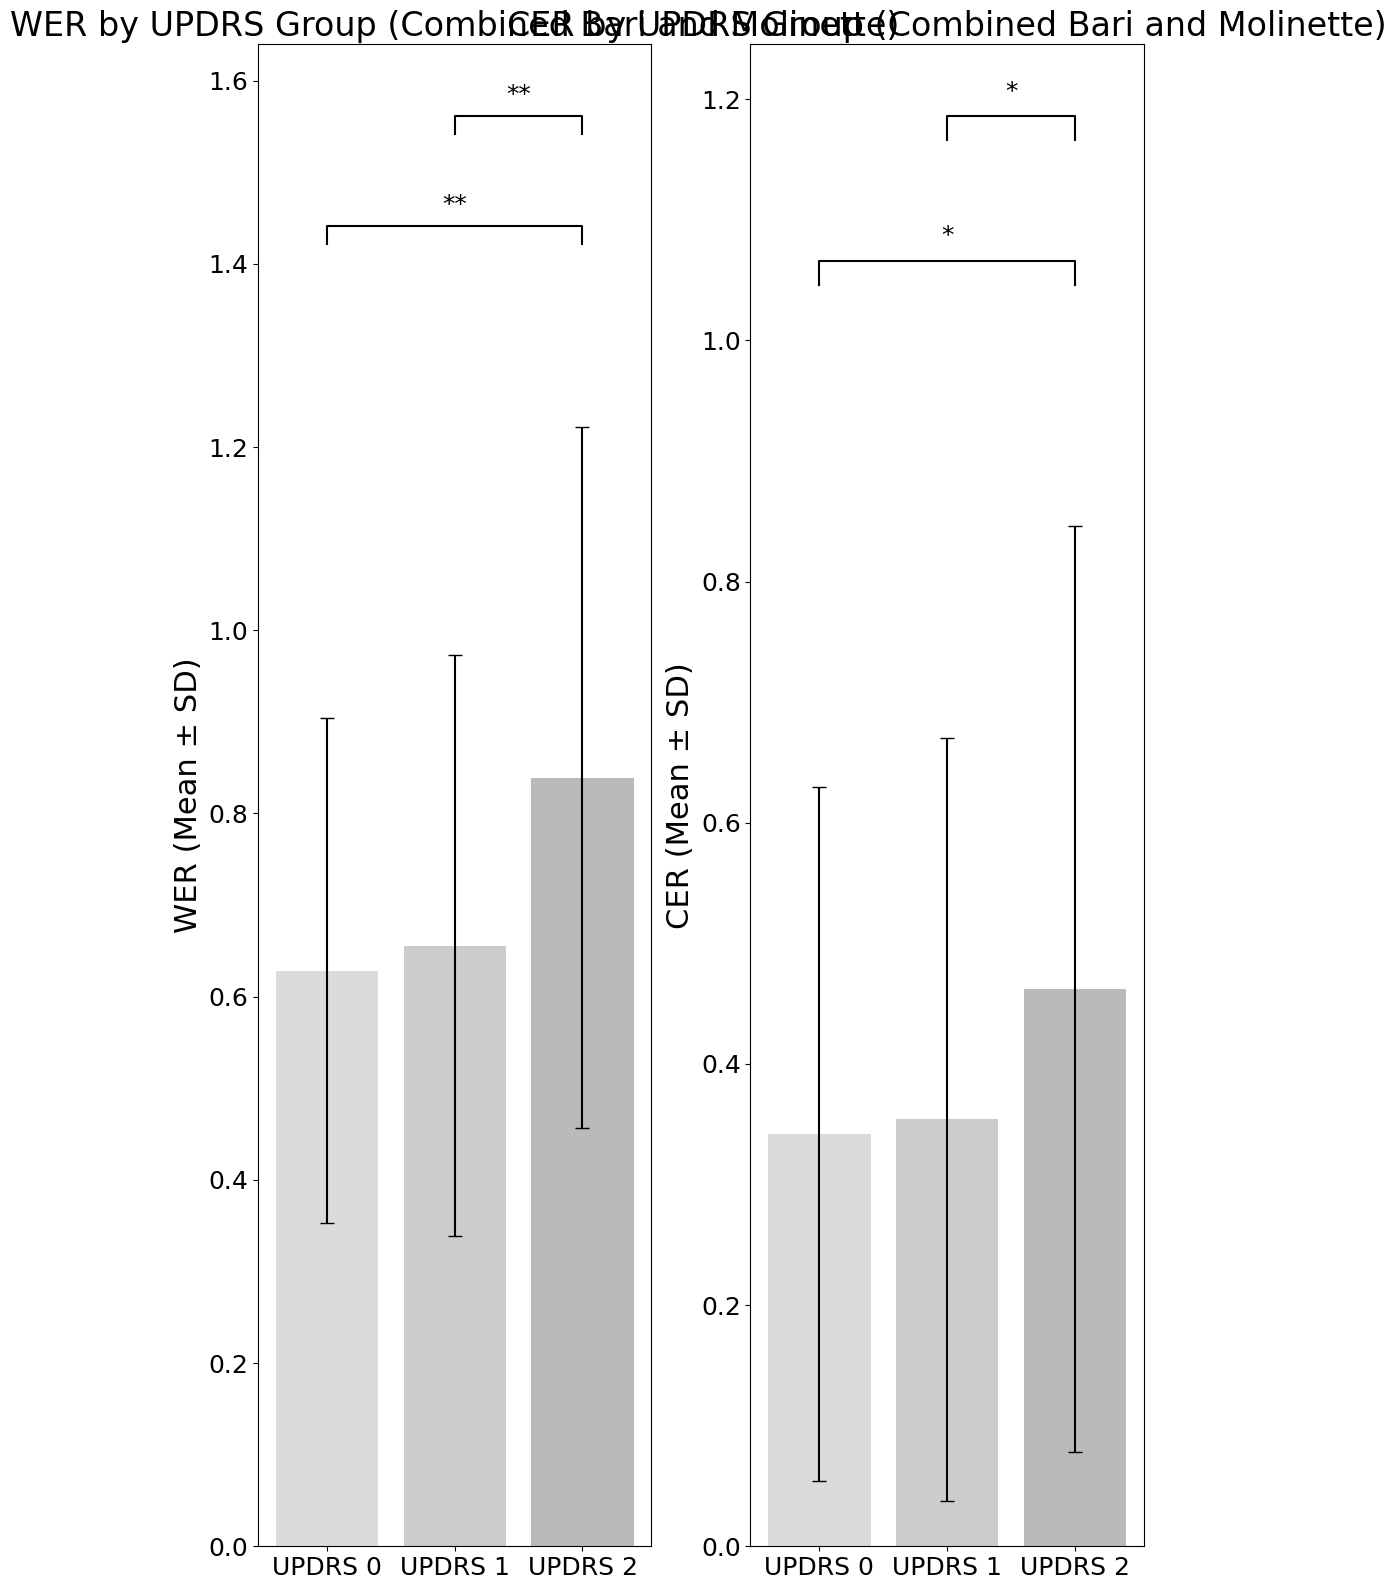

✅ Figure saved as 'statistics_combined.pdf' and displayed.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract means and standard deviations
wer_means = [final_results['combined_wer'][i]['mean_unweighted'] for i in range(3)]
wer_stds = [np.std(final_results['combined_wer'][i]['values']) for i in range(3)]
cer_means = [final_results['combined_cer'][i]['mean_unweighted'] for i in range(3)]
cer_stds = [np.std(final_results['combined_cer'][i]['values']) for i in range(3)]

# Define UPDRS groups and x positions
updrs_groups = ['UPDRS 0', 'UPDRS 1', 'UPDRS 2']
x_positions = np.arange(len(updrs_groups))

# Function to add significance annotations
def add_significance(ax, x1, x2, y, p_value, offset=0.02):
    if p_value < 0.0001:
        symbol = '****'
    elif p_value < 0.001:
        symbol = '***'
    elif p_value < 0.01:
        symbol = '**'
    elif p_value < 0.05:
        symbol = '*'
    else:
        return
    ax.plot([x1, x1, x2, x2], [y, y + offset, y + offset, y], color='black', linewidth=1.5)
    ax.text((x1 + x2) * 0.5, y + offset + 0.01, symbol,
            ha='center', va='bottom', color='black', fontsize=18)

# Colors for bars
bar_colors = ['lightgray', 'silver', 'darkgray']

# Height offsets for significance annotations
height_offsets = {(0, 1): 0.08, (0, 2): 0.20, (1, 2): 0.32}

# Create figure
fig, axes = plt.subplots(2, 1, figsize=(10, 16))

# WER Plot
ax = axes[0]
ax.bar(x_positions, wer_means, yerr=wer_stds, capsize=5, color=bar_colors, alpha=0.8)
ax.set_title('WER by UPDRS Group (Combined Bari and Molinette)', fontsize=24)
ax.set_xticks(x_positions)
ax.set_xticklabels(updrs_groups, fontsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.set_ylabel('WER (Mean ± SD)', fontsize=22)

# Add WER significance
wer_significance = dunn_results[0][1]
for (i, j) in height_offsets.keys():
    p_value = wer_significance.iloc[i, j]
    y = max(wer_means[i] + wer_stds[i], wer_means[j] + wer_stds[j]) + height_offsets[(i, j)]
    add_significance(ax, i, j, y, p_value, offset=0.02)

# CER Plot
ax = axes[1]
ax.bar(x_positions, cer_means, yerr=cer_stds, capsize=5, color=bar_colors, alpha=0.8)
ax.set_title('CER by UPDRS Group (Combined Bari and Molinette)', fontsize=24)
ax.set_xticks(x_positions)
ax.set_xticklabels(updrs_groups, fontsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.set_ylabel('CER (Mean ± SD)', fontsize=22)

# Add CER significance
cer_significance = dunn_results[1][1]
for (i, j) in height_offsets.keys():
    p_value = cer_significance.iloc[i, j]
    y = max(cer_means[i] + cer_stds[i], cer_means[j] + cer_stds[j]) + height_offsets[(i, j)]
    add_significance(ax, i, j, y, p_value, offset=0.02)

plt.tight_layout()

# Save as high-quality PDF
fig.savefig("/Users/benedettaperrone/Documents/TESI/TESI SCRITTA/Paper/Figures/statistics_combined.pdf",
            format='pdf', bbox_inches='tight')

plt.show()

print("✅ Figure saved as 'statistics_combined.pdf' and displayed.")

